In [161]:

import diffrax
from diffrax import diffeqsolve, ODETerm, Dopri5,SaveAt
import numpy as np
import jax.numpy as jnp
import jax

import equinox as eqx  # https://github.com/patrick-kidger/equinox
import matplotlib.pyplot as plt
import optax
import pandas as pd

    p_qsmax  p_Ks  p_a  p_ms
lb     -0.5   0.0 -1.8  -0.2
ub     -0.1   0.1 -1.4   0.0
{'p_qsmax': -0.14166174012065652, 'p_Ks': 0.09805681997506632, 'p_a': -1.5359252937693082, 'p_ms': -0.023969463265137075}


/tmp/ipykernel_17290/4055805379.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  random_init[name]=float(np.random.uniform(bounds[name]['lb'],bounds[name]['ub'],size=1))


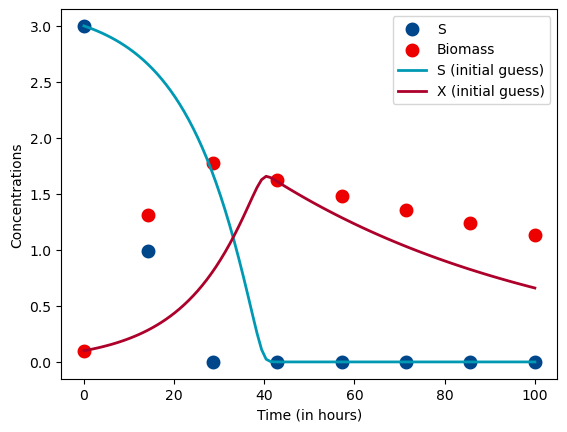

In [162]:
params={"p_qsmax":-0.3,"p_Ks":0.01,"p_a":-1.6,"p_ms":-0.01}




class Bioprocess_4p():
    def __init__(self):
        super().__init__()
    
    def __call__(self,t,y,args):
        params=args[0]
        
        qs=params['p_qsmax']*(y[0]/(params['p_Ks']+y[0]))
        qx=(qs-params['p_ms'])/params['p_a']

        Rs=qs*y[1]
        Rx=qx*y[1]
        dY=jnp.stack([Rs,Rx])
        return dY

class NeuralODE():
    func : Bioprocess_4p()

    def __init__(self):
        super().__init__()

        self.func=Bioprocess_4p()

    def __call__(self,ts,y0,params):
        solution = diffrax.diffeqsolve(
        diffrax.ODETerm(self.func),
        diffrax.Kvaerno3(),
        t0=ts[0],
        t1=ts[-1],
        dt0=ts[1] - ts[0],
        y0=y0,
        args=[params],
        stepsize_controller=diffrax.PIDController(rtol=1e-8, atol=1e-8),
        saveat=diffrax.SaveAt(ts=ts),
        max_steps=10000
        )
        return solution.ys



model_bioprocess=NeuralODE()
model_bioprocess=jax.jit(model_bioprocess)

ts=jnp.linspace(0,100,8)

y_names=["S",'Biomass']
y0=jnp.array([3,0.1])

ys=model_bioprocess(ts=ts,y0=y0,params=params)

plt.scatter(ts,ys[:,0],label=y_names[0],linewidth=4,c="#00468BFF")
plt.scatter(ts,ys[:,1],label=y_names[1],linewidth=4,c="#ED0000FF")
plt.xlabel("Time (in hours)")
plt.ylabel("Concentrations")



def uniform_sampling(bounds,N):
    """Takes a uniform sample between lower and upperbound values"""
    parameter_sets=[]
    names=list(bounds.keys())
    for i in range(N):
        random_init={}
        for name in names:
            random_init[name]=float(np.random.uniform(bounds[name]['lb'],bounds[name]['ub'],size=1))
        parameter_sets.append(random_init)

    return parameter_sets

##initialize prediction dataset
bounds=pd.read_csv("batch_bounds.csv",index_col=0).T

print(bounds)
bounds=dict(bounds)
parameter_set=uniform_sampling(bounds,1)
params_initial_guess=parameter_set[0]
print(params_initial_guess)
ts_ig=jnp.linspace(0,100,100)
ys_ig=model_bioprocess(ts=ts_ig,y0=y0,params=params_initial_guess)

plt.plot(ts_ig,ys_ig[:,0],label="S (initial guess)",linewidth=2,c="#0099B4FF")
plt.plot(ts_ig,ys_ig[:,1],label="X (initial guess)",linewidth=2,c="#AD002AFF")
plt.xlabel("Time (in hours)")
plt.ylabel("Concentrations")
plt.legend()

In [163]:
# ### simple learning system to test whether grads works as expected
def loss_func(params,ts,ys):
    """A very simple loss function, later we need to add functionality for missing data"""
    y_pred=model_bioprocess(ts,y0,params)
    return jnp.mean((ys - y_pred) ** 2)

lr=1e-3
optimizer = optax.adabelief(lr)


opt_state = optimizer.init(params_initial_guess)

print(loss_func(params_initial_guess,ts,ys))

@jax.jit
def update(opt_state,params,ts,ys):
    """Update rule for the gradients for parameters"""
    loss=loss_func(params,ts,ys)
    grads=jax.jit(jax.grad(loss_func,0))(params,ts,ys) #loss w.r.t. parameters
    updates,opt_state=optimizer.update(grads,opt_state)
    params = optax.apply_updates(params, updates)
    return opt_state,params,loss,grads



0.5076577


In [168]:
epochs=300
grads_list=[]

losses=[]
grads_list=[]
for _ in range(epochs):
    opt_state,params_initial_guess,loss,grads=update(opt_state,params_initial_guess,ts,ys)
    print(_,loss)
    losses.append(loss)


In [169]:
losses

[Array(0.11616029, dtype=float32),
 Array(0.1185682, dtype=float32),
 Array(0.12077495, dtype=float32),
 Array(0.12279532, dtype=float32),
 Array(0.12463817, dtype=float32),
 Array(0.12631844, dtype=float32),
 Array(0.12784937, dtype=float32),
 Array(0.12924258, dtype=float32),
 Array(0.13050951, dtype=float32),
 Array(0.13166068, dtype=float32),
 Array(0.1327063, dtype=float32),
 Array(0.13365522, dtype=float32),
 Array(0.13451596, dtype=float32),
 Array(0.13529667, dtype=float32),
 Array(0.13600442, dtype=float32),
 Array(0.13665, dtype=float32),
 Array(0.13722703, dtype=float32),
 Array(0.13775301, dtype=float32),
 Array(0.13822791, dtype=float32),
 Array(9.42262e+08, dtype=float32),
 Array(0.13988021, dtype=float32),
 Array(0.14098966, dtype=float32),
 Array(0.14198703, dtype=float32),
 Array(0.14289692, dtype=float32),
 Array(0.14372282, dtype=float32),
 Array(0.14447057, dtype=float32),
 Array(0.14514406, dtype=float32),
 Array(0.14575903, dtype=float32),
 Array(0.14631225, dtype

In [144]:
ys[0:2,]

Array([[3.       , 0.1      ],
       [0.9886223, 1.3149774]], dtype=float32)

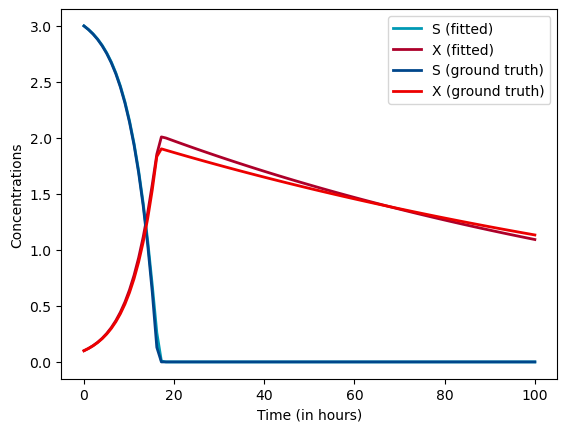

In [159]:
ts_ig=jnp.linspace(0,100,100)
ys_ig=model_bioprocess(ts=ts_ig,y0=y0,params=params_initial_guess)

ys=model_bioprocess(ts_ig,y0=y0,params=params)


plt.plot(ts_ig,ys_ig[:,0],label="S (fitted)",linewidth=2,c="#0099B4FF")
plt.plot(ts_ig,ys_ig[:,1],label="X (fitted)",linewidth=2,c="#AD002AFF")
plt.plot(ts_ig,ys[:,0],label="S (ground truth)",linewidth=2,c="#00468BFF")
plt.plot(ts_ig,ys[:,1],label="X (ground truth)",linewidth=2,c="#ED0000FF")
plt.xlabel("Time (in hours)")
plt.ylabel("Concentrations")
plt.legend()

